In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
%matplotlib inline

In [2]:
metadata_file = 'spcup_2022_training_part1\labels.csv'
metadata_file_unseen = 'spcup_2022_training_part1\labels_.csv'
df = pd.read_csv(metadata_file)
df.head()

,track,algorithm
0,00050dd7458cf08e594c797930696bce.wav,4
1,00070e7c531000d3dddc735d107275a9.wav,2
2,000f0711027a69b7f3886c2dbcb7d41f.wav,3
3,001e28e66dee24408aaf3480dfb95fbe.wav,1
4,001eee950f60613869544b72cd48fe97.wav,2


In [3]:
df2 = pd.read_csv(metadata_file_unseen)
df2.head()

,track,algorithm
0,7b0f8df28f98bdcd65e48d4799c1f98f.wav,5
1,211fbbdb342c2bbbac43fd4c908e239a.wav,5
2,807587f93df68fd50120fa1f3684b5ec.wav,5
3,78724d807be41abdd1a4d661d6535d1f.wav,5
4,86195fbf1d21aeeb9a956e56dd88f1b6.wav,5


In [4]:
final_df = pd.concat([df,df2],ignore_index=True)
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [5]:
final_df.head()

,track,algorithm
0,3b81ca25f63af7ad1c4c641f8a18de48.wav,3
1,44e1d1532ff104c5f9b5edfb4c834917.wav,1
2,bee1d05f6e3890dbe17785638c5cbaae.wav,3
3,d3403c7f77326f7ec70d95cf8d2c7c3c.wav,4
4,6b43b6344a8929dd279bcf22d8349223.wav,2


In [6]:
final_df.to_csv("hee.csv",index=False)

In [7]:
final_df['algorithm'].value_counts()

0    1000
4    1000
1    1000
5    1000
2    1000
3    1000
Name: algorithm, dtype: int64

In [27]:
file_name='spcup_2022_training_part1/8420a65c4f6eacd057f86ab32c48a23d.wav'
plt.figure(figsize=(14, 5))

audio_data, sampling_rate = librosa.load(file_name,sr=16000)
print(audio_data.shape,sampling_rate)
split_size=16000
end=np.int(len(audio_data)/split_size)

audio_data_splited = [audio_data[x:x+split_size] for x in range(0, split_size*end, split_size)]
len(audio_data_splited)

(203593,) 16000


12

<Figure size 1008x360 with 0 Axes>

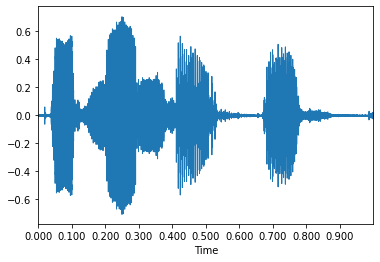

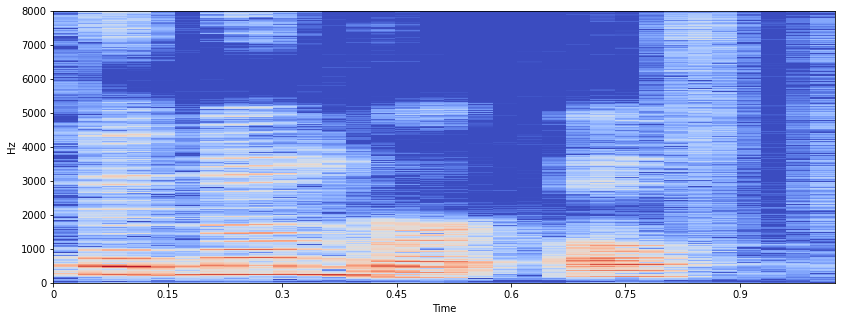

In [31]:
librosa.display.waveplot(audio_data_splited[0],sr=sampling_rate)     #visualizing audio

X = librosa.stft(audio_data_splited[0])      #spectogram
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')

In [155]:
ipd.Audio(file_name, rate=sampling_rate, autoplay=True)

In [156]:
#audio_data.shape

In [157]:
#mfccs_features = librosa.feature.mfcc(audio_data, sr=sampling_rate, n_mfcc=40)
#mfccs_features.shape

In [79]:
def features_extractor(audio,sample_rate):
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [80]:
extracted_features=[]
for index_num,row in tqdm(final_df.iterrows()):
    file_name = os.path.join('spcup_2022_training_part1/'+row["track"])
    final_class_labels=row["algorithm"]
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    end=np.int(len(audio)/sample_rate)
    audio_splitted = [audio[x:x+sample_rate] for x in range(0, sample_rate*end, sample_rate)]
    #print(len(audio),end=' ')
    for _ in audio_splitted:
        data=features_extractor(_,sample_rate)
        extracted_features.append([data,final_class_labels])
    #print(len(extracted_features))

6000it [07:03, 14.17it/s]


In [81]:
len(extracted_features)

38576

In [82]:
import random
random.shuffle(extracted_features)

In [83]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['track','algorithm'])
extracted_features_df.head(10)

,track,algorithm
0,"[-436.73343, 54.712746, -31.17688, 16.878983, ...",0
1,"[-236.26581, 109.6877, -49.32747, 65.219696, -...",1
2,"[-257.19714, 135.25871, -32.592735, 50.636913,...",3
3,"[-268.24442, 129.66846, -52.485607, 47.56522, ...",5
4,"[-266.66653, 124.62813, -33.26307, 11.239365, ...",5
5,"[-267.98178, 122.56573, -35.013287, 58.00021, ...",1
6,"[-217.73512, 145.35233, -59.056507, 34.925766,...",0
7,"[-206.26176, 144.34534, -57.039185, 37.140903,...",0
8,"[-292.43692, 153.25319, -8.048844, 22.851992, ...",3
9,"[-249.00844, 95.57471, -23.827423, 57.68114, -...",0


In [84]:
X=np.array(extracted_features_df['track'].tolist())
y=np.array(extracted_features_df['algorithm'].tolist())

In [85]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [91]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(6))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               4100      
_________________________________________________________________
activation_16 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_17 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)              

In [92]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [93]:
X_train.shape

(30860, 40)

In [94]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification_2.hdf5', verbose=1, save_best_only=True)  
#no num - first attempt with 6000 samples withoit truncating 40 mfcc - best / no dropout layers
#1 - 1s truncated 20 mfcc
#2 - 1s truncated with 22050Hz 40 mfcc


start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
965/965 [==============================] - 2s 1ms/step - loss: 7.9735 - accuracy: 0.2251 - val_loss: 1.0679 - val_accuracy: 0.5197

Epoch 00001: val_loss improved from inf to 1.06794, saving model to saved_models\audio_classification_2.hdf5
Epoch 2/200
965/965 [==============================] - 1s 1ms/step - loss: 1.1534 - accuracy: 0.4830 - val_loss: 0.6634 - val_accuracy: 0.6831

Epoch 00002: val_loss improved from 1.06794 to 0.66340, saving model to saved_models\audio_classification_2.hdf5
Epoch 3/200
965/965 [==============================] - 1s 1ms/step - loss: 0.8117 - accuracy: 0.6438 - val_loss: 0.5999 - val_accuracy: 0.7278

Epoch 00003: val_loss improved from 0.66340 to 0.59989, saving model to saved_models\audio_classification_2.hdf5
Epoch 4/200
965/965 [==============================] - 1s 1ms/step - loss: 0.6925 - accuracy: 0.6942 - val_loss: 0.5388 - val_accuracy: 0.7713

Epoch 00004: val_loss improved from 0.59989 to 0.53882, saving model to saved_models\audi

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


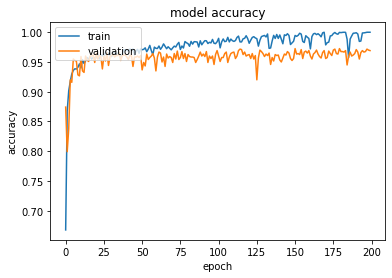

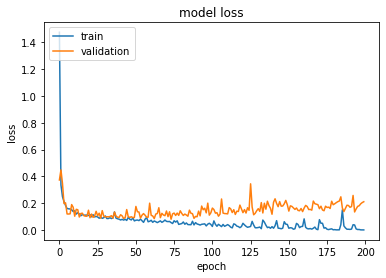

In [168]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


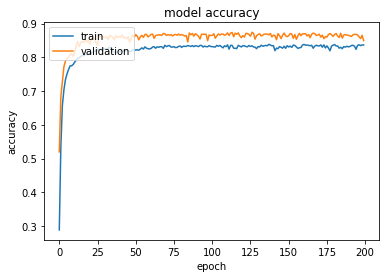

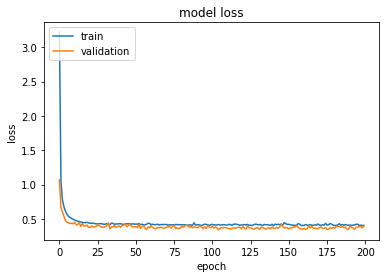

In [95]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()